# Proyek Predictive Analytics : Etherium

- **Nama:** Akbar Widianto
- **Email:** wdntoakbar@gmail.com
- **ID Dicoding:** wakbarr

# Summary
Proyek ini berfokus pada analisis keuangan untuk memprediksi harga Ethereum (ETH) menggunakan tiga algoritma machine learning: K-Nearest Neighbors (KNN), Random Forest, dan AdaBoost. Data yang digunakan adalah data historis harga Ethereum yang mencakup berbagai metrik harga harian, yang kemudian diproses untuk membangun model prediksi.

# Pengolahan Data


## Import Library

### Library berikut digunakan untuk analisis data, visualisasi, dan pemodelan:

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

## Memuat Dataset

### Dataset historis Ethereum dimuat dari file CSV dan diurutkan berdasarkan tanggal:

In [45]:
df = pd.read_csv('ethereum.csv')
df.sort_values(by='Date', inplace=True)
df.set_index('Date', inplace=True)
df.head()

,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,,,,
2015-08-08 23:59:59,1,Ethereum,ETH,2.798810,0.714725,2.793760,0.753325,674188.0,4.548689e+07
2015-08-09 23:59:59,2,Ethereum,ETH,0.879810,0.629191,0.706136,0.701897,532170.0,4.239957e+07
2015-08-10 23:59:59,3,Ethereum,ETH,0.729854,0.636546,0.713989,0.708448,405283.0,4.281836e+07
2015-08-11 23:59:59,4,Ethereum,ETH,1.131410,0.663235,0.708087,1.067860,1463100.0,6.456929e+07
2015-08-12 23:59:59,5,Ethereum,ETH,1.289940,0.883608,1.058750,1.217440,2150620.0,7.364501e+07


### Berikut adalah deskripsi kolom dalam dataset:

| No | Kolom       | Tipe Data | Penjelasan                                                            |
| -- | ----------- | --------- | --------------------------------------------------------------------- |
| 1  | `SNo`       | `int64`   | Nomor urut data, biasanya hanya sebagai index atau penanda baris      |
| 2  | `Name`      | `object`  | Nama koin kripto, dalam hal ini kemungkinan semua bernilai "Ethereum" |
| 3  | `Symbol`    | `object`  | Simbol dari koin, seperti `ETH`                                       |
| 4  | `High`      | `float64` | Harga tertinggi Ethereum dalam periode (misalnya harian)              |
| 5  | `Low`       | `float64` | Harga terendah Ethereum dalam periode                                 |
| 6  | `Open`      | `float64` | Harga saat pasar dibuka dalam periode itu                             |
| 7  | `Close`     | `float64` | Harga saat pasar ditutup dalam periode itu                            |
| 8  | `Volume`    | `float64` | Total volume perdagangan Ethereum (jumlah transaksi) dalam periode    |
| 9  | `Marketcap` | `float64` | Kapitalisasi pasar Ethereum = harga x total supply                    |



In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2160 entries, 2015-08-08 23:59:59 to 2021-07-06 23:59:59
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SNo        2160 non-null   int64  
 1   Name       2160 non-null   object 
 2   Symbol     2160 non-null   object 
 3   High       2160 non-null   float64
 4   Low        2160 non-null   float64
 5   Open       2160 non-null   float64
 6   Close      2160 non-null   float64
 7   Volume     2160 non-null   float64
 8   Marketcap  2160 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 168.8+ KB


## Praproses Data

### Kolom yang tidak relevan untuk analisis dihapus:

In [47]:
df.drop(['SNo', 'Name', 'Symbol', 'Volume', 'Marketcap'], axis=1, inplace=True)

### Fitur baru berupa rata-rata harga harian dibuat:

In [48]:
df['OHLC_Average'] = df[['Open', 'High', 'Low', 'Close']].mean(axis=1)

### Target prediksi, yaitu harga penutupan 30 hari ke depan, ditambahkan:

In [49]:
df['Price_After_Month'] = df['Close'].shift(-30)

### Baris dengan nilai kosong dihapus:

In [50]:
df.dropna(inplace=True)

## Penanganan Outlier

## Outlier dideteksi dan dihapus menggunakan metode IQR:

In [51]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

#Penjelasan Statistik dan Penanganan Outlier
Output statistik memberikan informasi penting terkait sebaran data untuk masing-masing kolom:

*   count: Jumlah total data yang tersedia pada kolom (bukan nilai kosong).

*   mean: Nilai rata-rata dari data pada kolom tersebut.

*   std: Standar deviasi, mengukur seberapa besar penyebaran data terhadap rata-ratanya.

*   min: Nilai terkecil pada kolom.

*   25% (Q1): Kuartil pertama, yaitu nilai di bawah 25% data berada.

*   50% (Median): Kuartil kedua atau nilai tengah dari data.

*   75% (Q3): Kuartil ketiga, yaitu nilai di bawah 75% data berada.

*   max: Nilai maksimum pada kolom.

Berdasarkan nilai Q1 dan Q3, kita dapat menghitung IQR (Interquartile Range) yang digunakan untuk mendeteksi outlier, yaitu nilai-nilai yang berada di luar rentang:

## Pemisahan Fitur dan Target

### Fitur (X) dan target (y) dipisahkan:

In [52]:
X = df.drop('Price_After_Month', axis=1)
y = df['Price_After_Month']

## Normalisasi Data

### Fitur dinormalisasi menggunakan StandardScaler:

In [53]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Pembagian Data

### Data dibagi menjadi 80% data latih dan 20% data uji:

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.8, random_state=42)

# Analisis Data Eksplorasi (EDA)

## Distribusi Data

### Histogram digunakan untuk melihat distribusi data:

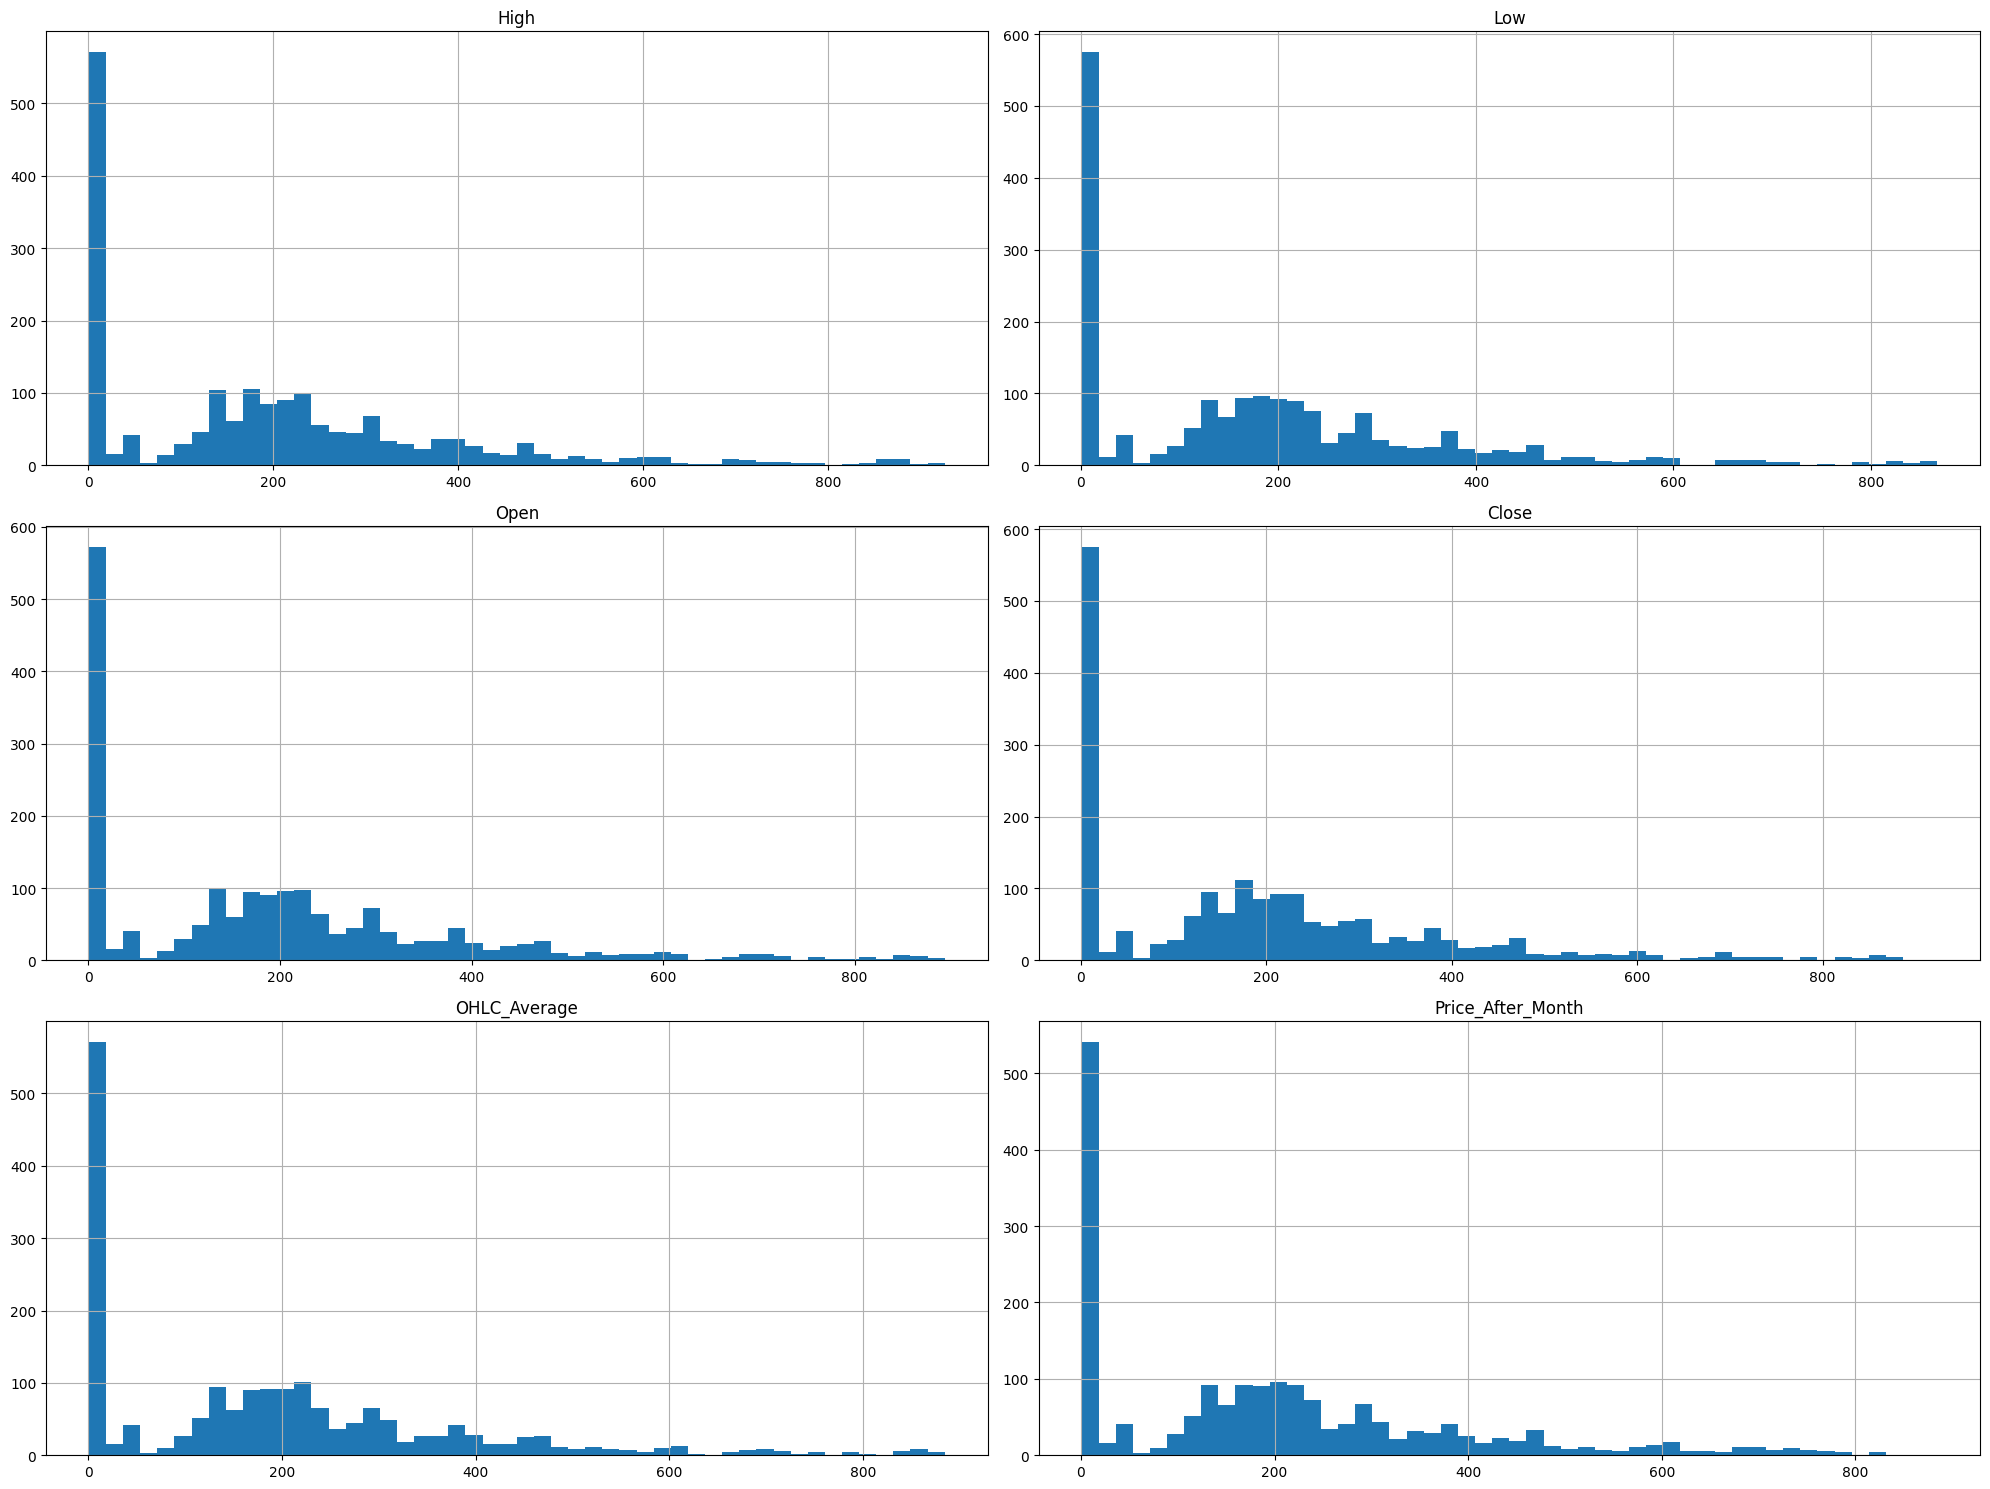

In [55]:
df.hist(bins=50, figsize=(20, 15))
plt.tight_layout()
plt.show()

## Hubungan Antar Fitur

### Matriks korelasi divisualisasikan untuk memahami hubungan antar variabel:

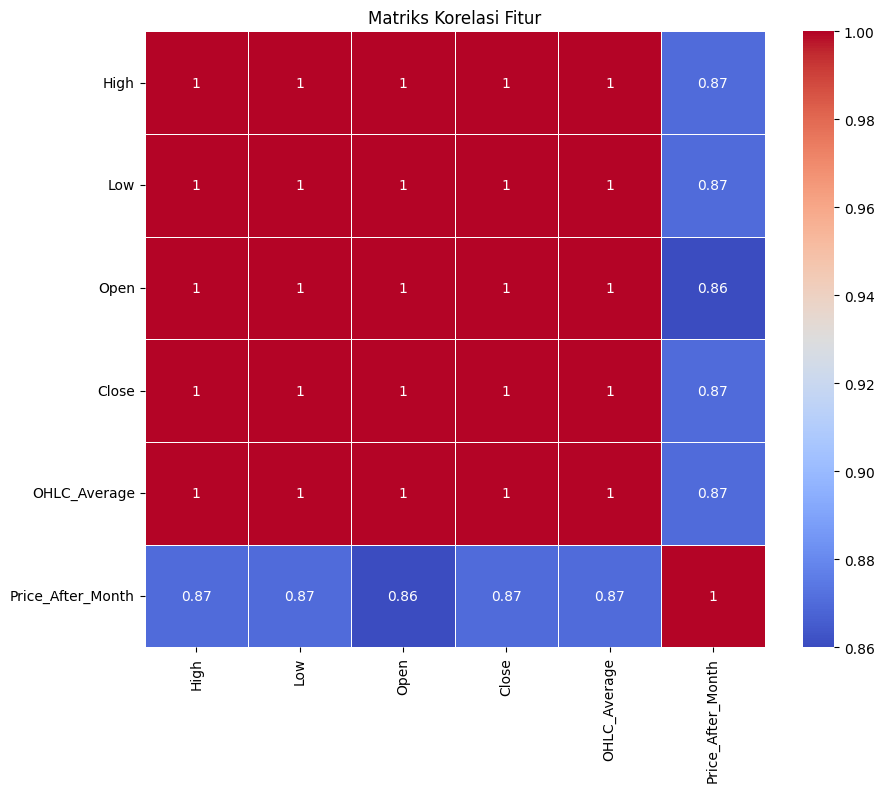

In [56]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr().round(2), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Matriks Korelasi Fitur")
plt.show()

# Pemodelan

## Inisialisasi dan Pelatihan Model

### Tiga model machine learning diinisialisasi dan dilatih:

In [57]:
# KNN
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)

# Random Forest
rf = RandomForestRegressor(n_estimators=50, max_depth=16, random_state=42)
rf.fit(X_train, y_train)

# AdaBoost
boosting = AdaBoostRegressor(n_estimators=50, learning_rate=0.05, random_state=42)
boosting.fit(X_train, y_train)

AdaBoostRegressor(learning_rate=0.05, random_state=42)

## Evaluasi Model

### Performa model diukur menggunakan MSE dan R² Score:

In [58]:
models = {'KNN': knn, 'Random Forest': rf, 'AdaBoost': boosting}
for name, model in models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - MSE: {mse:.2f}, R² Score: {r2:.4f}")

KNN - MSE: 6100.06, R² Score: 0.8259
Random Forest - MSE: 7163.01, R² Score: 0.7955
AdaBoost - MSE: 6203.98, R² Score: 0.8229


# Evaluasi dan Prediksi

## Prediksi Harga 30 Hari ke Depan

### Data 30 hari terakhir digunakan untuk memprediksi harga ke depan dengan model KNN:

In [59]:
X_future = X_scaled[-30:]
forecast = knn.predict(X_future)

forecast_dates = pd.date_range(start=pd.to_datetime(df.index[-1]), periods=31, freq='D')[1:]
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Predicted_Price': forecast})
forecast_df.set_index('Date', inplace=True)

print("\nPrediksi Harga Ethereum 30 Hari ke Depan:")
print(forecast_df.head())


Prediksi Harga Ethereum 30 Hari ke Depan:
                     Predicted_Price
Date                                
2020-12-04 23:59:59       418.081996
2020-12-05 23:59:59       484.174833
2020-12-06 23:59:59       464.706538
2020-12-07 23:59:59       410.913688
2020-12-08 23:59:59       484.110127


### Visualisasi hasil prediksi:

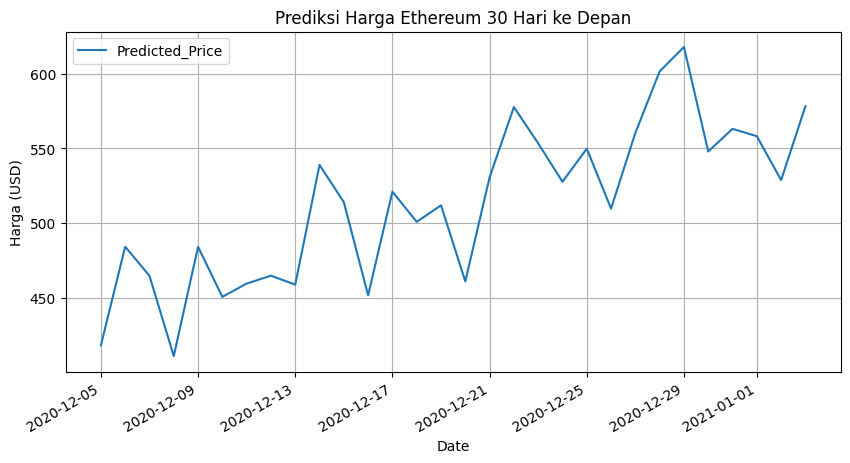

In [60]:
forecast_df.plot(figsize=(10, 5), title='Prediksi Harga Ethereum 30 Hari ke Depan')
plt.ylabel("Harga (USD)")
plt.grid(True)
plt.show()

## Perbandingan Prediksi dan Data Aktual

### Perbandingan antara harga aktual dan prediksi Random Forest untuk 100 data pertama:

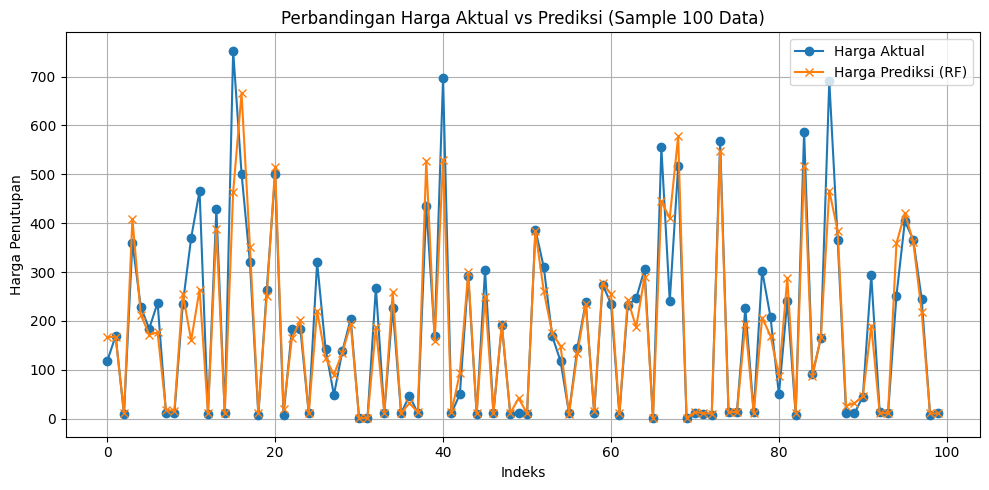

In [61]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:100], label='Harga Aktual', marker='o')
plt.plot(rf.predict(X_test)[:100], label='Harga Prediksi (RF)', marker='x')
plt.title('Perbandingan Harga Aktual vs Prediksi (Sample 100 Data)')
plt.xlabel('Indeks')
plt.ylabel('Harga Penutupan')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Proyek ini berhasil mengimplementasikan analisis dan prediksi harga Ethereum dengan pendekatan machine learning, memberikan wawasan tentang performa model dan potensi harga di masa depan.